In [118]:
import pandas as pd
from ast import literal_eval
import matplotlib
import platform
from scipy import stats

# 폰트 설정을 위한 코드
os_name = platform.system()
if os_name == "Darwin":
    matplotlib.rc("font", family="AppleGothic")
elif os_name == "Windows":
    matplotlib.rc("font", family="MalgunGothic")

In [119]:
# 데이터 불러오기 및 약간의 추가 전처리
laws_20 = pd.read_csv(
    "./data/laws_20_preprocessed.csv", converters={"repr_proposer": literal_eval}
)
lawmaker_20 = pd.read_csv("./data/lawmaker_20_preprocessed.csv")
laws_21 = pd.read_csv(
    "./data/laws_21_preprocessed.csv", converters={"repr_proposer": literal_eval}
)
lawmaker_21 = pd.read_csv("./data/lawmaker_21_preprocessed.csv")
laws_20["repr_proposer"] = laws_20["repr_proposer"].apply(lambda x: x[0])
laws_21["repr_proposer"] = laws_21["repr_proposer"].apply(lambda x: x[0])

## 1. 양대 정당의 발의 법률안의 수가 같을까?


In [128]:
df_21 = pd.merge(laws_21, lawmaker_21, right_on="HG_NM", left_on="repr_proposer")


def merge_party(x):
    if x in ["더불어민주당", "열린민주당", "더불어민주연합"]:
        return "더불어민주당"
    elif x in [
        "미래통합당",
        "미래한국당",
        "새누리당",
        "자유한국당",
        "국민의힘",
        "국민의미래",
    ]:
        return "국민의힘"
    else:
        return "기타"


df_21["party"] = df_21["POLY_NM"].apply(merge_party)
lawmaker_21["party"] = lawmaker_21["POLY_NM"].apply(merge_party)

<AxesSubplot: title={'center': '정당별 법안 발의 수'}, xlabel='party'>

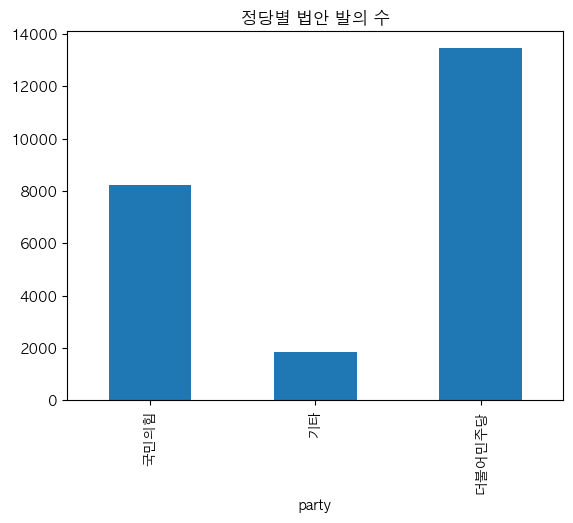

In [129]:
df_21.groupby(["party"]).size().plot(kind="bar", title="정당별 법안 발의 수")

### 1-1. 국회의원 1인당 기준으로 하면 다르지 않을까?


<AxesSubplot: title={'center': '정당별 국회의원 1인당 법안 발의 수'}>

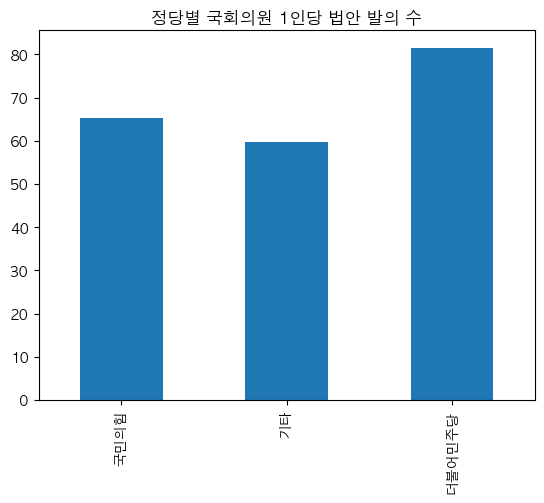

In [130]:
(df_21.groupby(["party"]).size() / lawmaker_21["party"].value_counts()).plot(
    kind="bar", title="정당별 국회의원 1인당 법안 발의 수"
)

## 1-2. 통계적으로 유의할 정도로 양당의 발의 법률안의 수가 다른가?


In [138]:
group_b

Series([], Name: cnt, dtype: int64)

In [139]:
# t-test. 국민의힘과 더불어민주당의 법안 발의 수 차이가 있는지 검정. 귀무가설: 두 그룹 간의 차이가 없다.
df = df_21.groupby(["HG_NM", "party"]).size().reset_index(name="cnt")
group_a = df[df["party"] == "더불어민주당"]["cnt"]
group_b = df[df["party"] == "국민의힘"]["cnt"]
group_c = df[df["party"] == "기타"]["cnt"]
t_statistic, p_value = stats.ttest_ind(group_a, group_b)

print(f"T-statistic: {t_statistic:.2f}")
print(f"P-value: {p_value:.4f}")

# Interpretation
if p_value < 0.05:
    print("두 그룹 간 법안 발의 수에는 유의한 차이가 있습니다.")
else:
    print("두 그룹 간 법안 발의 수에는 유의한 차이가 없습니다.")

T-statistic: 3.19
P-value: 0.0016
There is a significant difference between the two groups.


In [147]:
# 그러나 이 데이터는 해석에 유의해야 한다. t-test는 정규분포를 따르는 것을 전제하고 있지만, 이 데이터는 정규분포를 따르지 않을 수 있다.
from scipy import stats

# Shapiro-Wilk Test for group_a
stat_a, p_a = stats.shapiro(group_a)
print("Group A - Shapiro-Wilk Test")
print(f"Statistics={stat_a:.3f}, p={p_a:.4f}")
if p_a > 0.05:
    print("Group A looks Gaussian (fail to reject H0)")
else:
    print("Group A does not look Gaussian (reject H0)")

# Shapiro-Wilk Test for group_b
stat_b, p_b = stats.shapiro(group_b)
print("\nGroup B - Shapiro-Wilk Test")
print(f"Statistics={stat_b:.3f}, p={p_b:.4f}")
if p_b > 0.05:
    print("Group B looks Gaussian (fail to reject H0)")
else:
    print("Group B does not look Gaussian (reject H0)")

Group A - Shapiro-Wilk Test
Statistics=0.885, p=0.0000
Group A does not look Gaussian (reject H0)

Group B - Shapiro-Wilk Test
Statistics=0.925, p=0.0000
Group B does not look Gaussian (reject H0)


In [ ]:
# ANOVA. 세 그룹 간의 법안 발의 수 차이가 있는지 검정. 귀무가설: 세 그룹 간의 차이가 없다.
f_value, p_value = stats.f_oneway(group_a, group_b, group_c)

print(f"F-value: {f_value}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("세 그룹 간 법안 발의 수에는 유의한 차이가 있습니다.")
else:
    print("세 그룹 간 법안 발의 수에는 유의한 차이가 없습니다.")

In [148]:
# 비모수적 추정 방법인 Mann-Whitney U Test로 테스트 해본다.
from scipy.stats import mannwhitneyu

# Assuming group_a and group_b are your two independent samples
stat, p = mannwhitneyu(group_a, group_b)
print("Statistics=%.3f, p=%.3f" % (stat, p))
if p > 0.05:
    print("Probably the same distribution")
else:
    print("Probably different distributions")

Statistics=13097.000, p=0.000
Probably different distributions


## 2. 다선의원일수록 법률안을 많이 발의할까?


<AxesSubplot: title={'center': '법안 발의 수'}, xlabel='elected_cnt'>

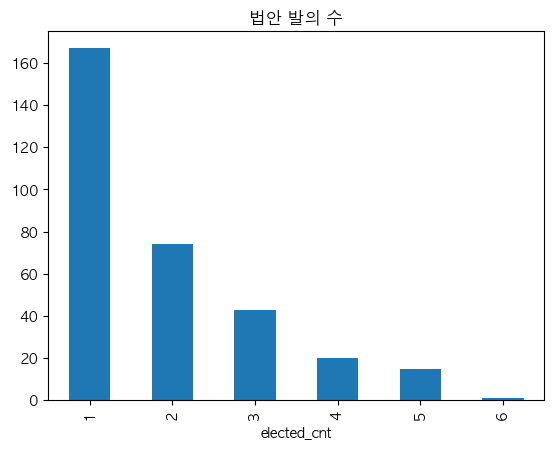

In [150]:
df2 = df_21.groupby(["HG_NM", "elected_cnt"]).size().reset_index(name="cnt")
df2.groupby(["elected_cnt"]).size().plot(kind="bar", title="법안 발의 수")

In [151]:
# ANOVA. 당선횟수에 따른 법안 발의 수 차이가 있는지 검정. 귀무가설: 당선횟수에 따른 차이가 없다.
from statsmodels.formula.api import ols
import statsmodels.api as sm

model = ols("cnt ~ C(elected_cnt)", data=df2).fit()
anova_result = sm.stats.anova_lm(model, typ=1)
print(anova_result)

# 0.05 이하의 p-value를 가지므로 당선횟수에 따른 법안 발의 수에는 유의한 차이가 있다.

                   df         sum_sq      mean_sq         F   PR(>F)
C(elected_cnt)    5.0   27743.826883  5548.765377  3.322312  0.00613
Residual        314.0  524427.723117  1670.151984       NaN      NaN


In [153]:
# Linear Regression
model = sm.OLS(df["cnt"], sm.add_constant(df2["elected_cnt"])).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     9.505
Date:                Thu, 04 Apr 2024   Prob (F-statistic):            0.00223
Time:                        08:37:50   Log-Likelihood:                -1641.9
No. Observations:                 320   AIC:                             3288.
Df Residuals:                     318   BIC:                             3295.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          84.9091      4.365     19.452      